# --- Block 1: Install Libraries and Setup Environment ---


In [1]:
!pip install -q kaggle tensorflow gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.1 MB/s eta 0:00:00


In [2]:
# Mount Google Drive for persistent storage
from google.colab import drive
drive.mount('/content/drive')

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d PlantVillage

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown


# --- Block 2: Import Libraries and Define Configurations ---


In [3]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, MobileNetV3Large
from tensorflow.keras.models import load_model
import gradio as gr
from PIL import Image


In [4]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
DATA_DIR = 'PlantVillage/PlantVillage'
EPOCHS = 20
MODEL_SAVE_DIR = '/content/drive/MyDrive/PlantDiseaseModels'  # Save to Google Drive
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# --- Block 3: Prepare Dataset ---


In [5]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [6]:
NUM_CLASSES = train_data.num_classes
CLASS_INDICES = train_data.class_indices
INVERSE_CLASS_INDICES = {v: k for k, v in CLASS_INDICES.items()}

# Save global class indices
with open(os.path.join(MODEL_SAVE_DIR, 'class_indices.json'), 'w') as f:
    json.dump(CLASS_INDICES, f)

# --- Block 4: Define Model Architectures ---

In [7]:
# VGG 16
def build_vgg():
    base = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    base.trainable = False
    return models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [8]:
# RezNet 50
def build_resnet():
    base = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    base.trainable = False
    return models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [9]:
# MobileNetV2

def build_mnv2():
    base = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    base.trainable = False
    return models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [10]:
def build_mnv3():
    base = MobileNetV3Large(alpha=1.0, input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    base.trainable = False
    return models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])


In [11]:
# 9_Layer_CNN
def build_custom_cnn():
    return models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(256, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

# --- Block 5: Training Utility ---

In [12]:
def compile_and_train(model, model_name):
    if os.path.exists(os.path.join(MODEL_SAVE_DIR, f"{model_name}.h5")):
        print(f"Model {model_name} already exists. Skipping training.")
        return None
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)
    model.save(os.path.join(MODEL_SAVE_DIR, f"{model_name}.h5"))
    with open(os.path.join(MODEL_SAVE_DIR, f"{model_name}_class_labels.json"), 'w') as f:
        json.dump(INVERSE_CLASS_INDICES, f)
    with open(os.path.join(MODEL_SAVE_DIR, f"{model_name}_history.json"), 'w') as f:
        json.dump({
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss']
        }, f)
    return history

# --- Block 6: Train Models ---

In [13]:
models_to_train = [
    (build_custom_cnn(), "cnn_9_layer"),
    (build_mnv2(), "mobilenetv2"),
    (build_vgg(), "vgg16"),
    (build_resnet(), "resnet50"),
    (build_mnv3(), "mobilenetv3")
]

for model, model_name in models_to_train:
    compile_and_train(model, model_name)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.3556 - loss: 1.9994 - val_accuracy: 0.7237 - val_loss: 0.8466
Epoch 2/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - accuracy: 0.7087 - loss: 0.8754 - val_accuracy: 0.8161 - val_loss: 0.5399
Epoch 3/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.8056 - loss: 0.5729 - val_accuracy: 0.8794 - val_loss: 0.3652
Epoch 4/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.8640 - loss: 0.4007 - val_accuracy: 0.9100 - val_loss: 0.2765
Epoch 5/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.8895 - loss: 0.3202 - val_accuracy: 0.8908 - val_loss: 0.3391
Epoch 6/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.9082 - loss: 0.2754 - val_accuracy: 0.9081 - val_loss: 0.2773
Epoch 7/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.9208 - loss: 0.2265 - val_accuracy: 0.9017 - val_loss: 0.2838
Epoch 8/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.9339 - loss: 0.20

Epoch 1/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.7112 - loss: 0.9323 - val_accuracy: 0.8848 - val_loss: 0.3430
Epoch 2/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.8809 - loss: 0.3570 - val_accuracy: 0.9064 - val_loss: 0.2807
Epoch 3/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - accuracy: 0.9042 - loss: 0.2810 - val_accuracy: 0.9061 - val_loss: 0.2619
Epoch 4/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.9138 - loss: 0.2423 - val_accuracy: 0.9170 - val_loss: 0.2511
Epoch 5/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.9270 - loss: 0.2051 - val_accuracy: 0.9175 - val_loss: 0.2545
Epoch 6/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 43s 38ms/step - accuracy: 0.9351 - loss: 0.1861 - val_accuracy: 0.9141 - val_loss: 0.2599
Epoch 7/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.9391 - loss: 0.1702 - val_accuracy: 0.9338 - val_loss: 0.2122
Epoch 8/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 39s 37ms/step - accuracy: 0.9520 -

Epoch 1/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 157s 143ms/step - accuracy: 0.5088 - loss: 1.5966 - val_accuracy: 0.7749 - val_loss: 0.7007
Epoch 2/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 127s 123ms/step - accuracy: 0.7831 - loss: 0.6751 - val_accuracy: 0.8134 - val_loss: 0.5579
Epoch 3/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 127s 123ms/step - accuracy: 0.8287 - loss: 0.5299 - val_accuracy: 0.8428 - val_loss: 0.4575
Epoch 4/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 127s 123ms/step - accuracy: 0.8403 - loss: 0.4704 - val_accuracy: 0.8428 - val_loss: 0.4550
Epoch 5/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 127s 123ms/step - accuracy: 0.8597 - loss: 0.4245 - val_accuracy: 0.8612 - val_loss: 0.4036
Epoch 6/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 127s 123ms/step - accuracy: 0.8761 - loss: 0.3774 - val_accuracy: 0.8721 - val_loss: 0.3599
Epoch 7/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 143s 138ms/step - accuracy: 0.8759 - loss: 0.3596 - val_accuracy: 0.8823 - val_loss: 0.3422
Epoch 8/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 186s 123ms/step - ac

Epoch 1/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 83s 67ms/step - accuracy: 0.1842 - loss: 2.4889 - val_accuracy: 0.2821 - val_loss: 2.1754
Epoch 2/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 57s 56ms/step - accuracy: 0.2933 - loss: 2.1153 - val_accuracy: 0.3578 - val_loss: 1.8664
Epoch 3/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.3583 - loss: 1.9025 - val_accuracy: 0.3506 - val_loss: 1.7988
Epoch 4/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 58s 56ms/step - accuracy: 0.4014 - loss: 1.7940 - val_accuracy: 0.4566 - val_loss: 1.6567
Epoch 5/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 67s 65ms/step - accuracy: 0.4091 - loss: 1.7430 - val_accuracy: 0.4755 - val_loss: 1.5797
Epoch 6/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 68s 66ms/step - accuracy: 0.4314 - loss: 1.6869 - val_accuracy: 0.4949 - val_loss: 1.5113
Epoch 7/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 58s 56ms/step - accuracy: 0.4452 - loss: 1.6397 - val_accuracy: 0.4932 - val_loss: 1.5245
Epoch 8/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 57s 55ms/step - accuracy: 0.4601 -

Epoch 1/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 63s 49ms/step - accuracy: 0.1773 - loss: 2.5001 - val_accuracy: 0.2770 - val_loss: 2.2194
Epoch 2/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.2558 - loss: 2.2128 - val_accuracy: 0.3231 - val_loss: 2.0674
Epoch 3/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.2935 - loss: 2.0973 - val_accuracy: 0.3311 - val_loss: 1.9676
Epoch 4/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - accuracy: 0.3240 - loss: 2.0057 - val_accuracy: 0.3765 - val_loss: 1.8955
Epoch 5/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.3456 - loss: 1.9372 - val_accuracy: 0.3857 - val_loss: 1.8434
Epoch 6/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.3573 - loss: 1.8887 - val_accuracy: 0.3862 - val_loss: 1.7828
Epoch 7/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.3751 - loss: 1.8449 - val_accuracy: 0.4253 - val_loss: 1.7190
Epoch 8/20
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.3949 -

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import json
import os


PLOT_SAVE_DIR = '/content/drive/MyDrive/PlantDiseaseModels/plots'  # Save plots
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

def display_model_summaries():
    model_configs = [
        (build_custom_cnn, "cnn_9_layer"),
        (build_vgg, "vgg16"),
        (build_resnet, "resnet50"),
        (build_mnv2, "mobilenetv2"),
        (build_mnv3, "mobilenetv3")
    ]
    for build_fn, model_name in model_configs:
        print(f"\n=== Model Summary for {model_name} ===")
        model = build_fn()
        model.summary()
        del model  # Free memory


In [15]:
def plot_training_history(model_name):
    history_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_history.json")
    if not os.path.exists(history_path):
        print(f"No history found for {model_name}. Skipping plot.")
        return

    with open(history_path, 'r') as f:
        history = json.load(f)

    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plot_path = os.path.join(PLOT_SAVE_DIR, f"{model_name}_history.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved training history plot for {model_name} at {plot_path}")


In [16]:
def plot_confusion_matrix(model_name):
    model_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}.h5")
    if not os.path.exists(model_path):
        print(f"No model found for {model_name}. Skipping confusion matrix.")
        return

    model = load_model(model_path)
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes

    cm = confusion_matrix(y_true, y_pred)
    labels = [INVERSE_CLASS_INDICES[i] for i in range(NUM_CLASSES)]

    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title(f'Confusion Matrix: {model_name}')

    plot_path = os.path.join(PLOT_SAVE_DIR, f"{model_name}_confusion_matrix.png")
    plt.savefig(plot_path)
    plt.close()
    print(f"Saved confusion matrix for {model_name} at {plot_path}")

# --- Block 7: Generate Summaries and Plots ---

In [17]:
display_model_summaries()



=== Model Summary for cnn_9_layer ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,821,007 (14.58 MB)

 Trainable params: 3,821,007 (14.58 MB)

 Non-trainable params: 0 (0.00 B)


=== Model Summary for vgg16 ===


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,985,039 (57.16 MB)

 Trainable params: 270,351 (1.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


=== Model Summary for resnet50 ===


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,644,495 (94.01 MB)

 Trainable params: 1,056,783 (4.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


=== Model Summary for mobilenetv2 ===


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


=== Model Summary for mobilenetv3 ===


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,246,223 (12.38 MB)

 Trainable params: 249,871 (976.06 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [18]:
model_names = ["cnn_9_layer", "vgg16", "resnet50", "mobilenetv2", "mobilenetv3"]
for model_name in model_names:
    plot_training_history(model_name)
    plot_confusion_matrix(model_name)

Saved training history plot for cnn_9_layer at /content/drive/MyDrive/PlantDiseaseModels/plots/cnn_9_layer_history.png


258/258 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step
Saved confusion matrix for cnn_9_layer at /content/drive/MyDrive/PlantDiseaseModels/plots/cnn_9_layer_confusion_matrix.png
Saved training history plot for vgg16 at /content/drive/MyDrive/PlantDiseaseModels/plots/vgg16_history.png


258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 102ms/step
Saved confusion matrix for vgg16 at /content/drive/MyDrive/PlantDiseaseModels/plots/vgg16_confusion_matrix.png
Saved training history plot for resnet50 at /content/drive/MyDrive/PlantDiseaseModels/plots/resnet50_history.png


258/258 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step
Saved confusion matrix for resnet50 at /content/drive/MyDrive/PlantDiseaseModels/plots/resnet50_confusion_matrix.png
Saved training history plot for mobilenetv2 at /content/drive/MyDrive/PlantDiseaseModels/plots/mobilenetv2_history.png


258/258 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step
Saved confusion matrix for mobilenetv2 at /content/drive/MyDrive/PlantDiseaseModels/plots/mobilenetv2_confusion_matrix.png
Saved training history plot for mobilenetv3 at /content/drive/MyDrive/PlantDiseaseModels/plots/mobilenetv3_history.png


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: 3.0 (of type <class 'float'>)

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Displaying history plot for: cnn_9_layer


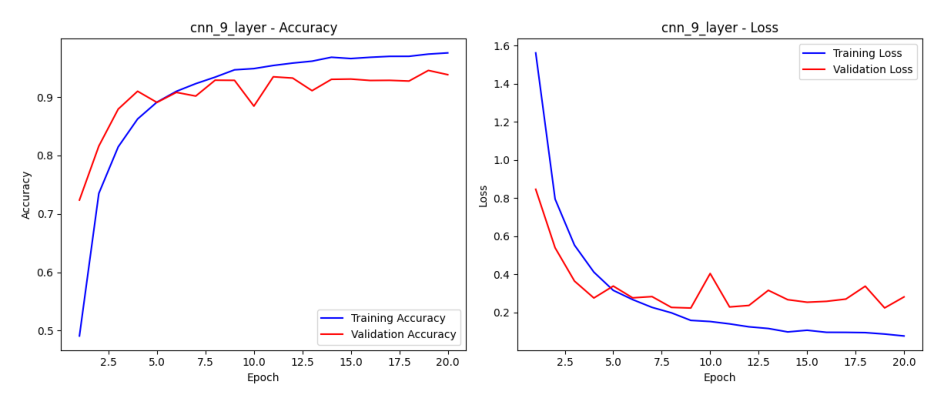

Displaying confusion matrix for: cnn_9_layer


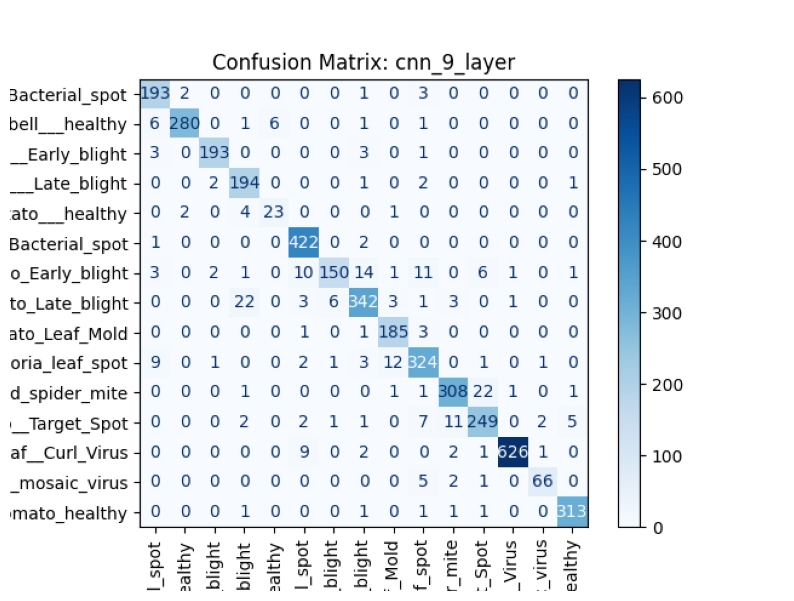

Displaying history plot for: vgg16


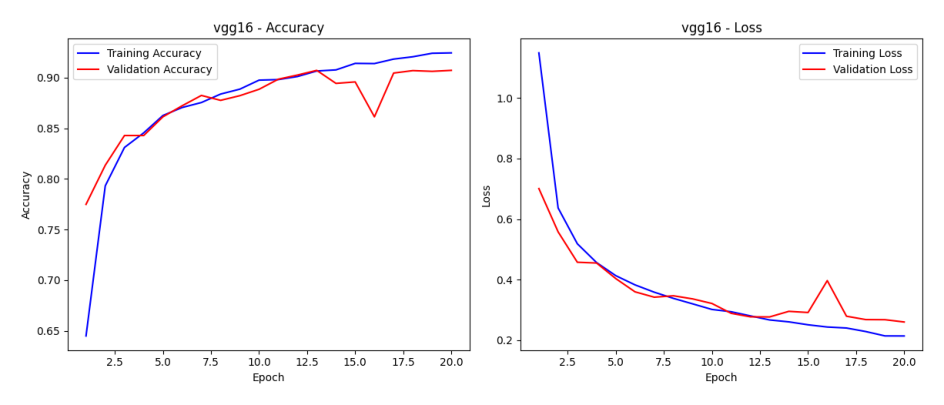

Displaying confusion matrix for: vgg16


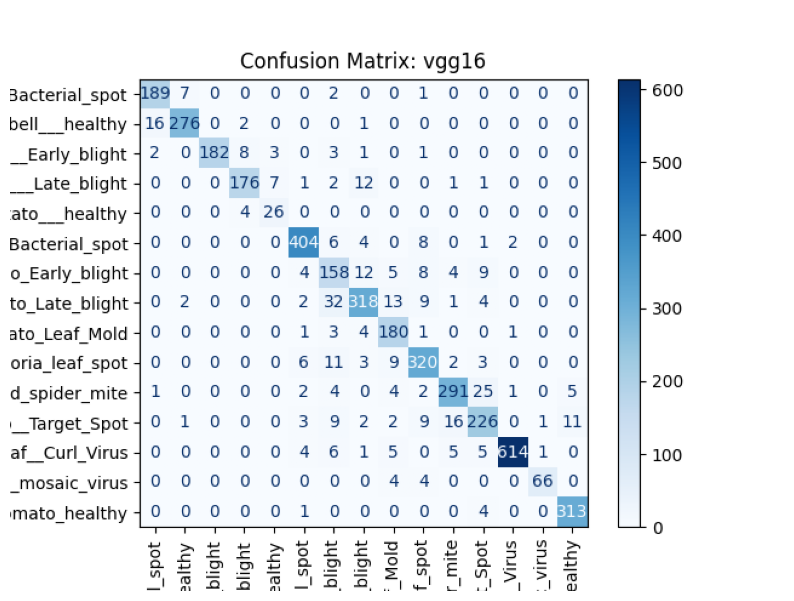

Displaying history plot for: resnet50


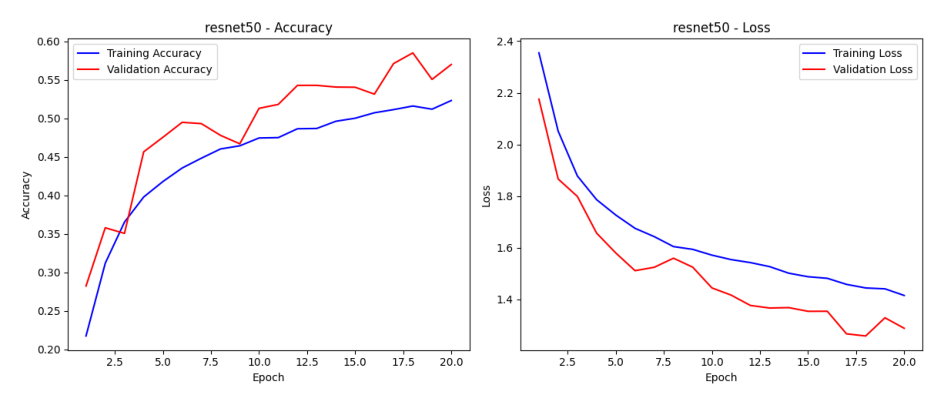

Displaying confusion matrix for: resnet50


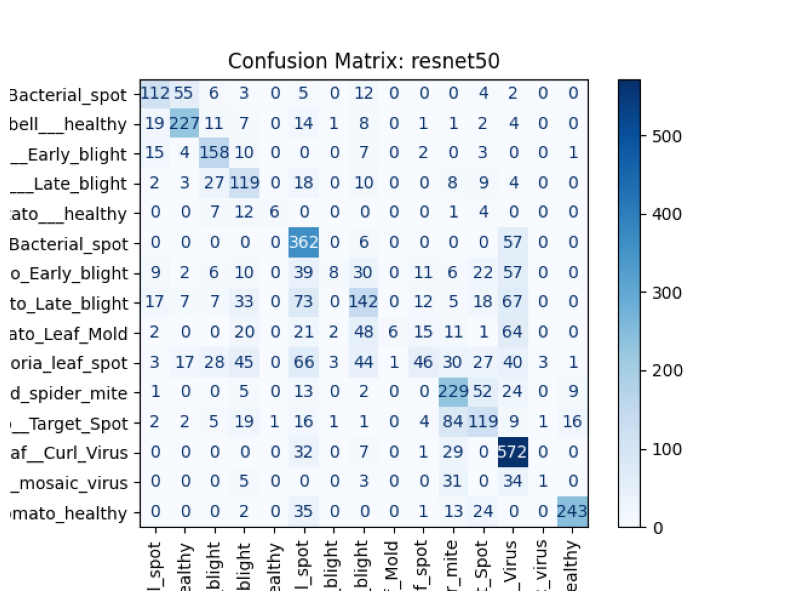

Displaying history plot for: mobilenetv2


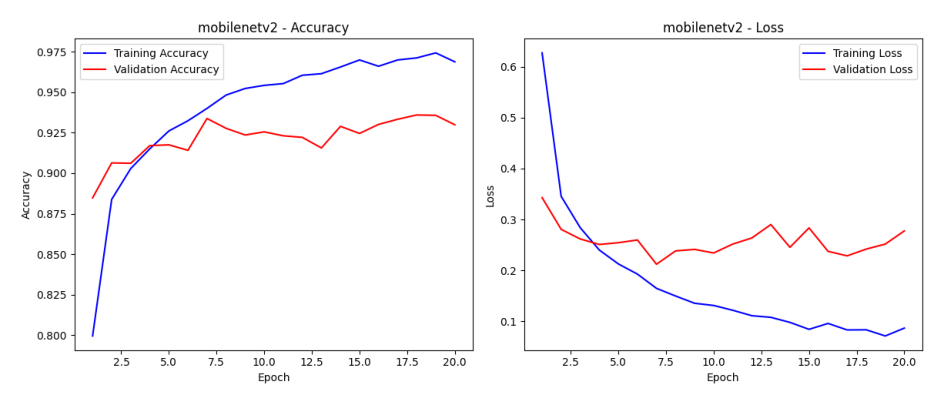

Displaying confusion matrix for: mobilenetv2


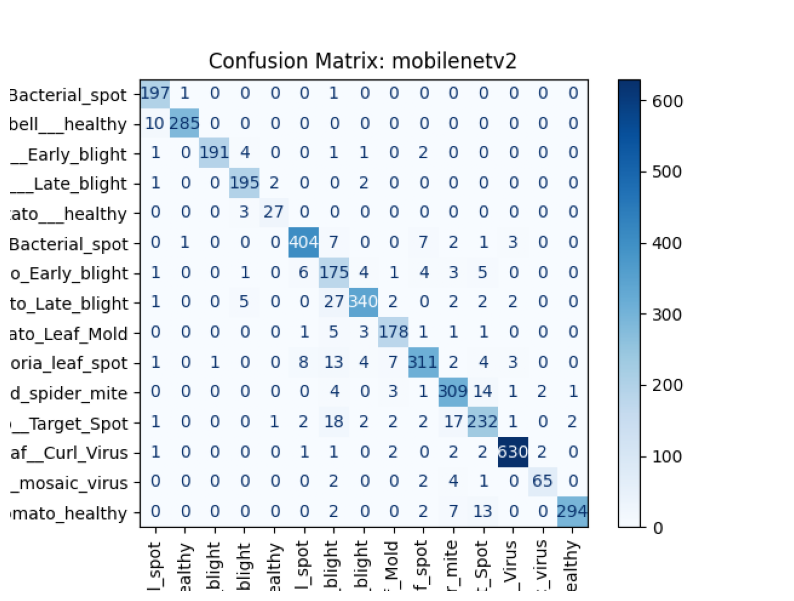

Displaying history plot for: mobilenetv3


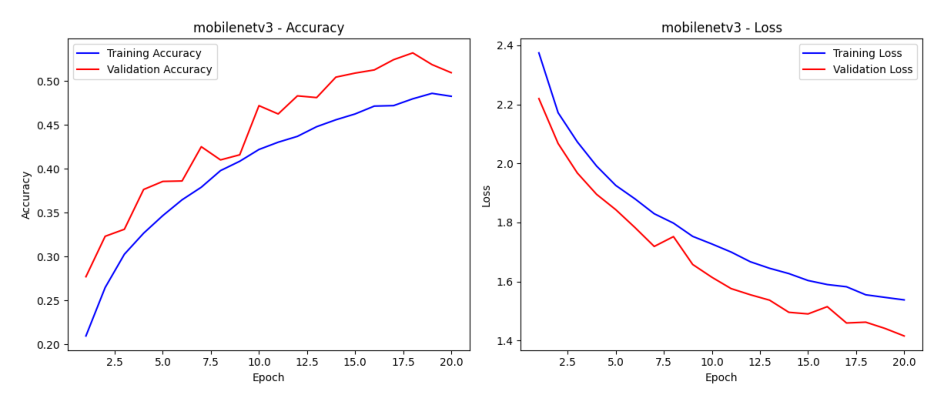

In [19]:
PLOT_SAVE_DIR = '/content/drive/MyDrive/PlantDiseaseModels/plots'

for model_name in model_names:
    history_plot_path = os.path.join(PLOT_SAVE_DIR, f"{model_name}_history.png")
    confusion_matrix_plot_path = os.path.join(PLOT_SAVE_DIR, f"{model_name}_confusion_matrix.png")

    if os.path.exists(history_plot_path):
        print(f"Displaying history plot for: {model_name}")
        plt.figure(figsize=(12, 5))
        img = plt.imread(history_plot_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    if os.path.exists(confusion_matrix_plot_path):
        print(f"Displaying confusion matrix for: {model_name}")
        plt.figure(figsize=(10, 8))
        img = plt.imread(confusion_matrix_plot_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()


# --- Block 8: Gradio GUI Functions ---

In [20]:
current_model = None
current_class_labels = {}

def load_selected_model(model_name):
    global current_model, current_class_labels
    model_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}.h5")
    labels_path = os.path.join(MODEL_SAVE_DIR, f"{model_name}_class_labels.json")

    if not os.path.exists(model_path):
        return f"❌ Error: Model '{model_name}' not found at {model_path}"
    if not os.path.exists(labels_path):
        return f"❌ Error: Class labels for '{model_name}' not found at {labels_path}"

    try:
        current_model = load_model(model_path)
        with open(labels_path, 'r') as f:
            current_class_labels = json.load(f)
            current_class_labels = {int(k): v for k, v in current_class_labels.items()}
        return f"✅ Model '{model_name}' and class labels loaded successfully!"
    except Exception as e:
        return f"❌ Error loading model: {str(e)}"

def predict_image(img, model_name):
    global current_model, current_class_labels
    if current_model is None or model_name not in current_model.name:
        status = load_selected_model(model_name)
        if "Error" in status:
            return status

    try:
        img = img.resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_batch = np.expand_dims(img_array, axis=0)

        prediction = current_model.predict(img_batch)
        class_index = int(np.argmax(prediction))
        class_label = current_class_labels.get(class_index, "Unknown")

        return f"🌿 Prediction: {class_label} (Model: {model_name})"
    except Exception as e:
        return f"❌ Error during prediction: {str(e)}"

# --- Block 9: Create and Launch Gradio GUI ---


In [21]:
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("<h1 style='text-align: center; color: #2E7D32;'>🌱 Plant Disease Detection Dashboard 🌱</h1>")

    with gr.Row():
        with gr.Column(scale=1):
            model_name = gr.Dropdown(
                choices=["vgg16", "resnet50", "mobilenetv2", "mobilenetv3", "cnn_9_layer"],
                label="Select Model",
                value="vgg16"
            )
            load_btn = gr.Button("Load Model", variant="primary")
            status_output = gr.Textbox(label="Model Load Status", lines=2)

        with gr.Column(scale=2):
            image_input = gr.Image(type="pil", label="Upload Leaf Image")
            predict_btn = gr.Button("Predict", variant="primary")
            result_output = gr.Textbox(label="Prediction Result", lines=2)

    load_btn.click(load_selected_model, inputs=model_name, outputs=status_output)
    predict_btn.click(predict_image, inputs=[image_input, model_name], outputs=result_output)

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://265ae65fe606c5a456.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
